In [21]:
import os
import sys
import polars as pl
import polars.selectors as cs
import plotly.express as px 

from datetime import datetime

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
from utils.paths import POSTPROCESSED_DATA_DIRECTORY
from utils.import_data import import_acropolis_system_data
from utils.plot_dataframes import plot_column_difference, plot_column

assert(os.path.exists(DATA_DIRECTORY))
assert(os.path.exists(POSTPROCESSED_DATA_DIRECTORY))

In [22]:
df_7 = import_acropolis_system_data(years=[2024,2025], target_directory=POSTPROCESSED_DATA_DIRECTORY, id=7, prefix="1min")

df_14 = import_acropolis_system_data(years=[2024,2025], target_directory=POSTPROCESSED_DATA_DIRECTORY, id=14, prefix="1min")

start_date = datetime(2024, 6, 21, 0, 0, 0)
end_date = datetime(2025, 3, 31, 23, 59, 59)

df = pl.concat([df_7, df_14], how="diagonal") \
    .filter(pl.col("datetime") >= start_date) \
    .filter(pl.col("datetime") <= end_date) \
    .select(["datetime", "system_id", "gmp343_corrected", "gmp343_temperature","sht45_humidity","bme280_pressure","h2o_v%"]) \
    .with_columns(pl.when((pl.col("system_id") == 14)).then(48).otherwise(85).alias("measurement_height")) \
    .sort("datetime") \
    .collect()

In [23]:
df.tail()

datetime,system_id,gmp343_corrected,gmp343_temperature,sht45_humidity,bme280_pressure,h2o_v%,measurement_height
datetime[ms],i32,f64,f64,f64,f64,f64,i32
2025-02-25 08:15:00,7,480.714187,32.65,20.20585,939.843333,1.061487,85
2025-02-25 08:15:00,14,480.812522,33.116667,19.21175,937.661667,1.038486,48
2025-02-25 08:16:00,7,475.713333,32.675,20.17945,938.6225,1.062973,85
2025-02-25 08:16:00,14,477.214371,33.133333,19.16565,939.206667,1.035257,48
2025-02-25 08:17:00,14,473.160955,33.1,19.048675,938.78,1.027483,48


In [24]:
df.write_csv(os.path.join(DATA_DIRECTORY, "output", "export", "ACROPOLIS_Blutenburgstrasse.csv"))

In [25]:
df_7 = df.filter(pl.col("system_id") == 7).rename({"gmp343_corrected": "gmp343_corrected_7"})
df_14 = df.filter(pl.col("system_id") == 14).rename({"gmp343_corrected": "gmp343_corrected_14"})

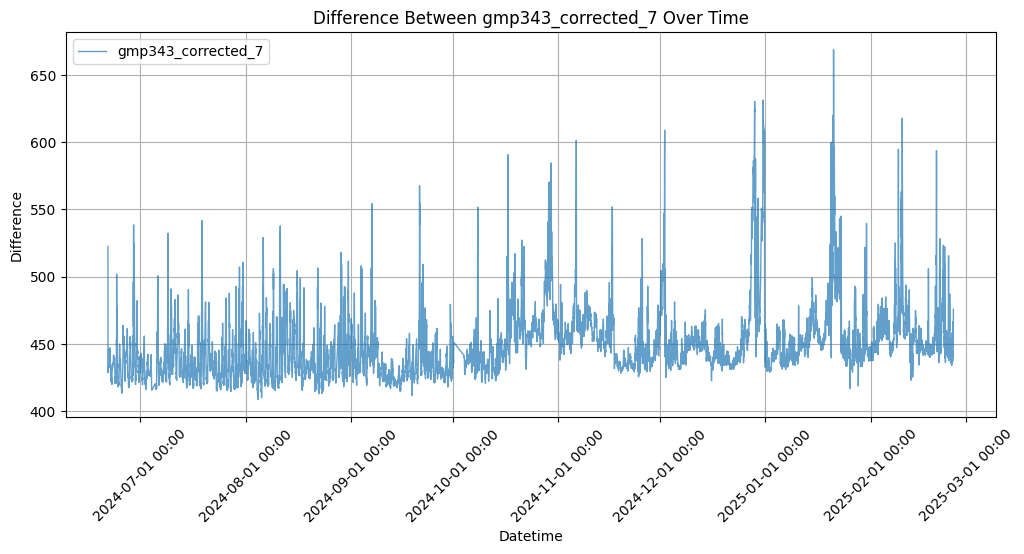

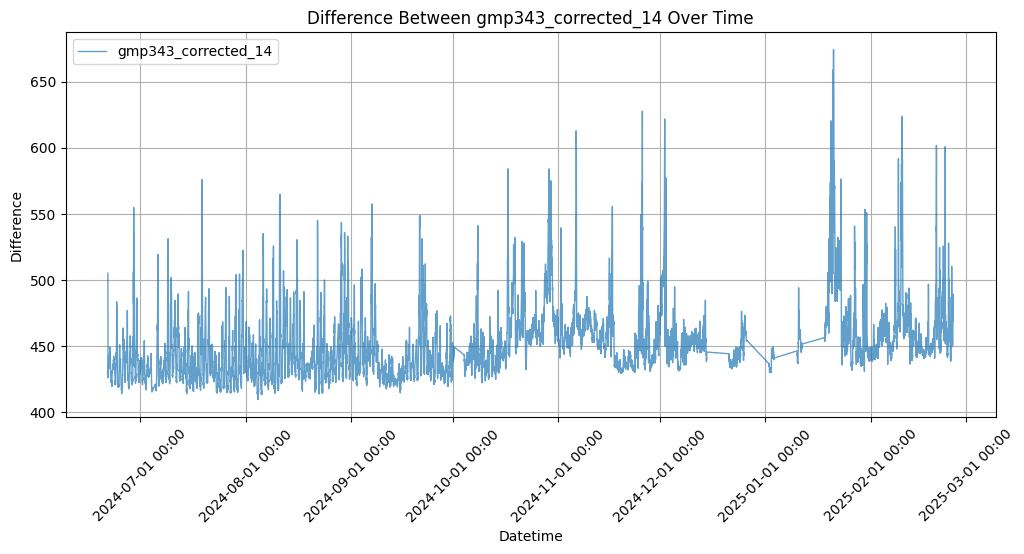

In [26]:
plot_column(df=df_7, datetime_col="datetime", col1="gmp343_corrected_7")
plot_column(df=df_14, datetime_col="datetime", col1="gmp343_corrected_14")

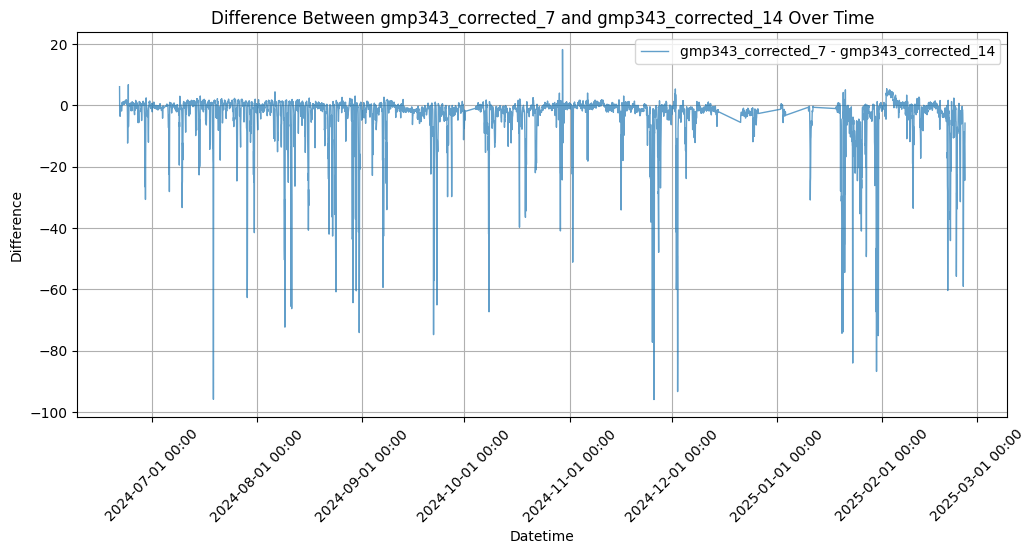

In [27]:
df_plot = df_7.join(df_14, on="datetime", how="left") \
    .sort("datetime") \
    .group_by_dynamic("datetime", every='1h', group_by=["system_id"]) \
    .agg([cs.numeric().mean()])

plot_column_difference(df=df_plot, datetime_col= "datetime",col1= "gmp343_corrected_7",col2="gmp343_corrected_14",sample_size= 10000)

In [ ]:
start_date = datetime(2025, 2, 18, 0, 0, 0)
end_date = datetime(2025, 2, 28, 23, 59, 59)

df_plot = df.filter(pl.col("datetime") >= start_date).filter(pl.col("datetime") <= end_date) \
    .sort("datetime") \
    .group_by_dynamic("datetime", every='10m', group_by=["system_id"]) \
    .agg([cs.numeric().mean()])

fig = px.line(df_plot, x="datetime", y=["gmp343_corrected"], markers=True, color="system_id")
fig.show()